# (i) Acquire and Process WaPOR data

In [ ]:
import ee
import requests
import pandas as pd
from osgeo import gdal

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-lscogill4')  # Replace with your actual project ID

In [ ]:
# First download v2 data for time series before 2018

# Define your parameters
base_url = "https://data.apps.fao.org/gismgr/api/v2/catalog/workspaces/WAPOR-2/mapsets"
mapset_code = "L1-AETI-M"
point_coords = (29.25197, -28.9936)  #  flux tower coordinates

In [ ]:
# Helper function to fetch mapset and raster information
def collect_responses(url, info=["code"]):
    data = {"links": [{"rel": "next", "href": url}]}
    output = []
    while "next" in [x["rel"] for x in data["links"]]:
        url_ = [x["href"] for x in data["links"] if x["rel"] == "next"][0]
        response = requests.get(url_)
        response.raise_for_status()
        data = response.json()["response"]
        output += [tuple(x.get(y) for y in info) for x in data["items"]]
    return sorted(output)


In [ ]:
# Get the raster data for 2014 to 2016 only
all_rasters = collect_responses(f"{base_url}/{mapset_code}/rasters", info=["code", "downloadUrl"])
filtered_rasters = [raster for raster in all_rasters if any(year in raster[0] for year in ["2014", "2015", "2016", "2017"])]


In [ ]:
# Initialize dataframe to store results
results = []

# Loop over each monthly raster
for raster_code, tif_url in filtered_rasters:
    ds = gdal.Open(f"/vsicurl/{tif_url}")
    if ds is None:
        print(f"Error: Could not open {tif_url}")
        continue

    # Calculate pixel coordinates for the point
    transform = ds.GetGeoTransform()
    x_pixel = int((point_coords[0] - transform[0]) / transform[1])
    y_pixel = int((point_coords[1] - transform[3]) / transform[5])

    # Read the pixel value
    band = ds.GetRasterBand(1)
    array = band.ReadAsArray(x_pixel, y_pixel, 1, 1)
    pixel_value = array[0, 0]

    # Check for NoData value
    if pixel_value == band.GetNoDataValue():
        pixel_value = None  # Set to None if NoData
    else:
        pixel_value *= 0.1  # Multiply by scale factor 0.1 if data is valid

    # Append results with date info from raster_code (assuming the code includes date information)
    results.append({"Raster_Code": raster_code, "ET_Value": pixel_value})

In [ ]:
# Convert results to a pandas DataFrame
et_df = pd.DataFrame(results)
# Remove the text 'WAPOR-2.L1-AETM-M.' from each cell in 'Raster_Code'
et_df['date'] = et_df['Raster_Code'].str.replace('WAPOR-2.L1-AETI-M.', '', regex=False)

# Drop the old 'Raster_Code' column
et_df = et_df.drop(columns=['Raster_Code'])

# Show the updated DataFrame
et_df.head()

# Save to CSV or analyze as needed
et_df.to_csv("monthly_waporv2_data.csv", index=False)

In [ ]:
# Now download v3 data for time series after 2018

# Define URL
base_url = f"https://data.apps.fao.org/gismgr/api/v2/catalog/workspaces/WAPOR-3/mapsets"

# Write function that requests the url and returns some of the information that's found.
def collect_responses(url, info=["code"]):
    data = {"links": [{"rel": "next", "href": url}]}
    output = list()
    while "next" in [x["rel"] for x in data["links"]]:
        url_ = [x["href"] for x in data["links"] if x["rel"] == "next"][0]
        response = requests.get(url_)
        response.raise_for_status()
        data = response.json()["response"]
        if isinstance(info, list):
            output += [tuple(x.get(y) for y in info) for x in data["items"]]
        else:
            output += data["items"]
    if isinstance(info, list):
        output = sorted(output)
    return output

In [ ]:
# Run the function on the URL we defined above
all_mapsets = collect_responses(base_url, info=["code", "caption"])

# Choose a specific mapset code
mapset_code = "L2-AETI-M"
mapset_url = f"{base_url}/{mapset_code}/rasters"
all_rasters = collect_responses(mapset_url, info=["code", "downloadUrl"])
all_rasters

[('WAPOR-3.L2-AETI-M.2018-01',
  'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-AETI-M/WAPOR-3.L2-AETI-M.2018-01.tif'),
 ('WAPOR-3.L2-AETI-M.2018-02',
  'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-AETI-M/WAPOR-3.L2-AETI-M.2018-02.tif'),
 ('WAPOR-3.L2-AETI-M.2018-03',
  'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-AETI-M/WAPOR-3.L2-AETI-M.2018-03.tif'),
 ('WAPOR-3.L2-AETI-M.2018-04',
  'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-AETI-M/WAPOR-3.L2-AETI-M.2018-04.tif'),
 ('WAPOR-3.L2-AETI-M.2018-05',
  'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-AETI-M/WAPOR-3.L2-AETI-M.2018-05.tif'),
 ('WAPOR-3.L2-AETI-M.2018-06',
  'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-AETI-M/WAPOR-3.L2-AETI-M.2018-06.tif'),
 ('WAPOR-3.L2-AETI-M.2018-07',
  'https://storage.googleapis.com/fao-gismgr-wapor-3-data

In [ ]:
# Download the first raster URL from all_rasters
tif_url = all_rasters[0][1]

# Define the point coordinates (longitude, latitude)
point_coords = (29.25197, -28.9936)  # flux-tower coordinates

# Open the COG file from the URL
ds = gdal.Open(f"/vsicurl/{tif_url}")
if ds is None:
    print(f"Error: Could not open {tif_url}")
    print(gdal.GetLastErrorMsg())
else:
    # Convert lat/lon to pixel coordinates
    transform = ds.GetGeoTransform()
    x_pixel = int((point_coords[0] - transform[0]) / transform[1])
    y_pixel = int((point_coords[1] - transform[3]) / transform[5])

    # Read the value of the pixel
    band = ds.GetRasterBand(1)
    array = band.ReadAsArray(x_pixel, y_pixel, 1, 1)

    # Check if the pixel value is NoData and handle appropriately
    pixel_value = array[0, 0]
    if pixel_value == band.GetNoDataValue():
        print("No data available at this point.")
    else:
        print("Evapotranspiration value at the point:", pixel_value)

Evapotranspiration value at the point: 927


In [ ]:
#Creating a GEE ImageCollection
#Using the all_rasters and mapset-code variables we've defined above we can also create an Google Earth Engine image-collection.
#First we need to create some Google Storage URLS using the raster and mapset codes.

gs_urls = [f"gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/{mapset_code}/{raster_code[0]}.tif" for raster_code in all_rasters] #subset: [:5]
gs_urls

['gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-AETI-M/WAPOR-3.L2-AETI-M.2018-01.tif',
 'gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-AETI-M/WAPOR-3.L2-AETI-M.2018-02.tif',
 'gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-AETI-M/WAPOR-3.L2-AETI-M.2018-03.tif',
 'gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-AETI-M/WAPOR-3.L2-AETI-M.2018-04.tif',
 'gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-AETI-M/WAPOR-3.L2-AETI-M.2018-05.tif',
 'gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-AETI-M/WAPOR-3.L2-AETI-M.2018-06.tif',
 'gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-AETI-M/WAPOR-3.L2-AETI-M.2018-07.tif',
 'gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-AETI-M/WAPOR-3.L2-AETI-M.2018-08.tif',
 'gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-AETI-M/WAPOR-3.L2-AETI-M.2018-09.tif',
 'gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-AETI-M/WAPOR-3.L2-AETI-M.2018-10.tif',
 'gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-AETI-M/WAPOR-3.L

In [ ]:
import ee
import re

In [ ]:
# Step 1: Authenticate and initialize Earth Engine with the project ID
ee.Authenticate()
ee.Initialize(project='ee-lscogill4')  # Replace with your actual project ID

# Step 2: Define a revised version of the create_collection function
def create_collection(urls):
    img_list = ee.List([])

    for url_ in urls:
        try:
            # Assuming we don't need regex and band names are straightforward
            band_name = url_.split("/")[-1].split(".")[0]  # Extract the file name before ".tif"
            img_list = img_list.add(ee.Image.loadGeoTIFF(url_).select(["B0"], [band_name]))
        except Exception as e:
            print(f"Error processing URL {url_}: {e}")

    return ee.ImageCollection(img_list)

# Step 3: Call the function with your `gs_urls`
gs_urls = [f"gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/{mapset_code}/{raster_code[0]}.tif" for raster_code in all_rasters]
collection = create_collection(gs_urls)

# Example usage: Print the collection info
print(collection.getInfo())

{'type': 'ImageCollection', 'bands': [], 'features': [{'type': 'Image', 'bands': [{'id': 'WAPOR-3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'dimensions': [368640, 122880], 'crs': 'GEOGCS["WGS 84", \n  DATUM["World Geodetic System 1984", \n    SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], \n    AUTHORITY["EPSG","6326"]], \n  PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]], \n  UNIT["degree", 0.017453292519943295], \n  AXIS["Geodetic longitude", EAST], \n  AXIS["Geodetic latitude", NORTH], \n  AUTHORITY["EPSG","4326"]]', 'crs_transform': [0.0009765625, 0, -180, 0, -0.0009765625, 60]}], 'properties': {'system:index': '0'}}, {'type': 'Image', 'bands': [{'id': 'WAPOR-3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'dimensions': [368640, 122880], 'crs': 'GEOGCS["WGS 84", \n  DATUM["World Geodetic System 1984", \n    SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","

In [ ]:
# Loop through each image in the collection and export it
image_collection = create_collection(gs_urls)
images = image_collection.toList(image_collection.size())
# Define your region using your specified coordinates
region = ee.Geometry.Point([29.25197, -28.9936])

for i in range(image_collection.size().getInfo()):
    image = ee.Image(images.get(i))

    # Define export parameters
    export_task = ee.batch.Export.image.toAsset(
        image=image,
        description=f"exported_image_{i}",
        assetId=f"users/lscogill4/exported_image_{i}",  # Update with your GEE username
        scale=100,  # Adjust as needed
        region=region,
        maxPixels=1e9
    )
    export_task.start()

In [ ]:
import ee
import pandas as pd

# Initialize the Earth Engine module
ee.Initialize()


In [ ]:
# Define the number of images you have
N = 72  # Change this to the actual number of your images (i.e. 12 = 1 year)

# Create a list of raster asset IDs
raster_assets = [f"users/lscogill4/exported_image_{i}" for i in range(N)]

# Function to generate date list
def generate_dates(start_year, start_month, num_months):
    dates = []
    for i in range(num_months):
        year = start_year + (start_month + i - 1) // 12
        month = (start_month + i - 1) % 12 + 1  # month should be 1-12
        dates.append(f"{year}{month:02d}")  # Format to YYYYMM
    return dates

# Generate the list of dates starting from January 2018
start_year = 2018
start_month = 1
date_list = generate_dates(start_year, start_month, N)

output_csv = 'monthly_waporv3_data.csv'

def extract_monthly_et(asset_ids, dates):
    monthly_et_data = []

    for asset_id, date_str in zip(asset_ids, dates):
        try:
            # Load the raster asset
            image = ee.Image(asset_id)

            # Check the available bands in the image
            band_names = image.bandNames().getInfo()
            if not band_names:
                print(f"No bands found for {asset_id}.")
                continue

            # Use the first available band if specific band name is not found
            band_name = band_names[0]  # Change this if you know the specific band name
            print(f"Processing {asset_id} with band: {band_name}")

            # Calculate mean ET value
            mean_et = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=image.geometry(),
                scale=100,  # Change scale as needed
                maxPixels=1e13
            ).get(band_name)  # Use the dynamic band name

            # Append the result to the list
            monthly_et_data.append({"date": date_str, "mean_et": mean_et.getInfo()})  # Get the value

        except Exception as e:
            print(f"Error processing {asset_id}: {e}")

    # Convert the list to a DataFrame
    df = pd.DataFrame(monthly_et_data)

    # Ensure the DataFrame has a 'date' column before proceeding
    if 'date' not in df.columns:
        print("No 'date' column in the DataFrame. Aborting save.")
        return

    # Convert the 'date' column to datetime format
    df['date'] = pd.to_datetime(df['date'], format='%Y%m')  # Convert to datetime

    # Save the DataFrame to a CSV file
    df.to_csv(output_csv, index=False)
    print(f"Monthly ET data summarized and saved to {output_csv}")

# Run the function with your raster asset IDs and generated dates
extract_monthly_et(raster_assets, date_list)

Processing users/lscogill4/exported_image_0 with band: WAPOR-3
Processing users/lscogill4/exported_image_1 with band: WAPOR-3
Processing users/lscogill4/exported_image_2 with band: WAPOR-3
Processing users/lscogill4/exported_image_3 with band: WAPOR-3
Processing users/lscogill4/exported_image_4 with band: WAPOR-3
Processing users/lscogill4/exported_image_5 with band: WAPOR-3
Processing users/lscogill4/exported_image_6 with band: WAPOR-3
Processing users/lscogill4/exported_image_7 with band: WAPOR-3
Processing users/lscogill4/exported_image_8 with band: WAPOR-3
Processing users/lscogill4/exported_image_9 with band: WAPOR-3
Processing users/lscogill4/exported_image_10 with band: WAPOR-3
Processing users/lscogill4/exported_image_11 with band: WAPOR-3
Processing users/lscogill4/exported_image_12 with band: WAPOR-3
Processing users/lscogill4/exported_image_13 with band: WAPOR-3
Processing users/lscogill4/exported_image_14 with band: WAPOR-3
Processing users/lscogill4/exported_image_15 with 

In [ ]:
import pandas as pd

# Load WAPOR data
wapor_df = pd.read_csv('monthly_waporv3_data.csv')

# Multiply all numeric columns by 0.1
wapor_df.iloc[:, 1:] *= 0.1  # Assuming the first column is 'date'

# Save the modified data over the old file
wapor_df.to_csv('monthly_waporv3_data.csv', index=False)

In [ ]:
# Merge v2 (2009 - 2017) and v3 (2018 - 2024) data into a single df

# Load the CSV files into DataFrames
df_v2 = pd.read_csv('monthly_waporv2_data.csv')
df_v3 = pd.read_csv('monthly_waporv3_data.csv')

# Show the first few rows and the column names of each DataFrame to inspect their structure
df_v3.head(), df_v3.columns, df_v2.head(), df_v2.columns

(         date    mean_et
 0  2018-01-01  82.378853
 1  2018-02-01  67.153869
 2  2018-03-01  60.848080
 3  2018-04-01  45.172504
 4  2018-05-01  26.903105,
 Index(['date', 'mean_et'], dtype='object'),
    ET_Value     date
 0     118.2  2014-01
 1      76.6  2014-02
 2      67.3  2014-03
 3      44.0  2014-04
 4      22.7  2014-05,
 Index(['ET_Value', 'date'], dtype='object'))

In [ ]:
# Convert 'date' columns to a consistent 'YYYY-MM' format
df_v3['date'] = pd.to_datetime(df_v3['date']).dt.to_period('M').astype(str)
df_v2['date'] = pd.to_datetime(df_v2['date'], format='%Y-%m').dt.to_period('M').astype(str)

# Merge the two dataframes on the 'date' column
merged_df = pd.merge(df_v2, df_v3, on='date', how='outer')

# Create a single column 'et_wapor' by combining 'ET_Value' and 'mean_et'
merged_df['et_wapor'] = merged_df['ET_Value'].combine_first(merged_df['mean_et'])

# Drop the now redundant columns 'ET_Value' and 'mean_et'
merged_df = merged_df[['date', 'et_wapor']]

# Display the final merged dataframe
merged_df.head()


,date,et_wapor
0,2014-01,118.2
1,2014-02,76.6
2,2014-03,67.3
3,2014-04,44.0
4,2014-05,22.7


In [ ]:
# Now save merged_df as a csv
merged_df.to_csv('monthly_wapor_data.csv', index=False)

# (ii) Acquire and Process MOD16 data

In [ ]:
import csv
import ee

In [ ]:
# Load MOD16 ET dataset
mod16 = ee.ImageCollection('MODIS/061/MOD16A2GF').filterBounds(region)

# Function to process MOD16 data
def process_mod16(image):

    # Exclude invalid values (water bodies, urban areas, etc.)
    mask = image.select('ET').lt(65529)  #
    et_mm = image.select('ET').updateMask(mask).multiply(0.1)  # Apply scaling factor

    # Calculate monthly mean ET
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    mean_value = et_mm.reduceRegion(reducer=ee.Reducer.mean(), geometry=region, scale=500).getInfo()

    return {'date': date.getInfo(), 'MOD16': mean_value.get('ET')}


In [ ]:
# Apply the function to each MOD16 image in the collection
mod16_means = []
# Retrieve the list of images in the collection
mod16_images = mod16.filterDate('2014-06-01', '2023-09-01').toList(mod16.size())

# Loop through the list of images
for i in range(mod16_images.size().getInfo()):
    image = ee.Image(mod16_images.get(i))
    monthly_mean = process_mod16(image)
    mod16_means.append(monthly_mean)

# Write MOD16 data to CSV
with open('mod16_means.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=['date', 'MOD16'])
    writer.writeheader()
    writer.writerows(mod16_means)

print("MOD16 data summarized and saved to mod16_means.csv")

MOD16 data summarized and saved to mod16_means.csv


In [ ]:
import csv
import ee
import pandas as pd

# Initialize the Earth Engine module
ee.Initialize()

In [ ]:
# Load MOD16 ET dataset
mod16 = ee.ImageCollection('MODIS/061/MOD16A2GF').filterBounds(region)  # Using your predefined region

# Function to process MOD16 data
def process_mod16(image):
    # Exclude invalid values (masking out fill values)
    mask = image.select('ET').lt(65529)
    et_mm = image.select('ET').updateMask(mask).multiply(0.1)  # Apply scaling factor

    # Calculate the month and year from the image date
    date = ee.Date(image.get('system:time_start'))
    date_str = date.format('YYYY-MM').getInfo()  # Get the date as Year-Month

    # Calculate the spatial mean ET for the image
    mean_value = et_mm.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,  # Use your predefined region
        scale=500,  # Use a reasonable scale; adjust if needed
        maxPixels=1e6,  # Set a limit for maxPixels
        bestEffort=False  # Disable best effort to focus on the exact region
    ).getInfo()

    # Check if 'ET' key exists in mean_value and if it's not None
    # If 'ET' is None or not found, return 0 for MOD16
    et_value = mean_value.get('ET')
    return {'date': date_str, 'MOD16': et_value if et_value is not None else 0}

# Initialize a dictionary to accumulate monthly totals
monthly_totals = {}

# Get the list of images in the collection for the specified date range
image_list = mod16.filterDate('2014-06-01', '2023-09-01').toList(mod16.size())

# Iterate through the MOD16 images and accumulate monthly means
for i in range(image_list.size().getInfo()):
    image = ee.Image(image_list.get(i))  # Get the image from the list
    monthly_mean = process_mod16(image)
    date_key = monthly_mean['date']

    if date_key not in monthly_totals:
        monthly_totals[date_key] = 0
    # Add the spatial mean value (in mm) to the total for the month
    monthly_totals[date_key] += monthly_mean['MOD16']

In [ ]:
# Convert to a DataFrame for easy manipulation and export
mod16_monthly_df = pd.DataFrame(list(monthly_totals.items()), columns=['date', 'MOD16'])

# Write MOD16 monthly totals to CSV
mod16_monthly_df.to_csv('monthly_mod16_data.csv', index=False)

# (iii) Acquire and Process SMAP data

In [ ]:
import ee
import pandas as pd
ee.Authenticate()
ee.Initialize()

In [ ]:
# definte region
region = region

# Define the date range
start_date = '2015-04-01'
end_date = '2023-09-01'

smap = ee.ImageCollection("NASA/SMAP/SPL4SMGP/007")

In [ ]:
# Filter the SMAP dataset by region and date
filtered_smap = smap.filterBounds(region).filterDate(start_date, end_date)


In [ ]:
# Define a function to calculate monthly ET sums
def calculate_monthly_et_sum(image_collection, date_str):
    """Calculates the monthly sum of ET for a given image collection and date.

    Args:
        image_collection (ee.ImageCollection): The image collection to process.
        date_str (str): The date string in 'YYYY-MM' format.

    Returns:
        dict: A dictionary containing the date and monthly ET sum.
    """
    monthly_smap_et = image_collection.select('land_evapotranspiration_flux').sum().reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region,
        scale=11000,
        maxPixels=1e9
    )
    return {
        'Date': date_str,
        'Monthly_ET': monthly_smap_et.get('land_evapotranspiration_flux').getInfo()
    }

# Define a function to calculate monthly sums
def calculate_monthly_sums(collection):
    """Calculates monthly sums of ET for the given collection.

    Args:
        collection (ee.ImageCollection): The image collection to process.

    Returns:
        list: A list of dictionaries containing the date and monthly ET sum for each month.
    """
    start = ee.Date(start_date)
    end = ee.Date(end_date)
    months = ee.List.sequence(0, end.difference(start, 'months').subtract(1))
    results = []

    def monthly_composite(month_offset):
        month_start = start.advance(month_offset, 'months')
        month_end = month_start.advance(1, 'months')
        date_str = month_start.format('YYYY-MM').getInfo()
        monthly_images = collection.filterDate(month_start, month_end)
        et_result = calculate_monthly_et_sum(monthly_images, date_str)
        results.append(et_result)

    for month_offset in months.getInfo():
        monthly_composite(month_offset)

    return results

# Calculate monthly ET sums
monthly_et_smap_results = calculate_monthly_sums(filtered_smap)

# Convert the results to a DataFrame
monthly_smap_et_df = pd.DataFrame(monthly_et_smap_results)

# Display the DataFrame
print(monthly_smap_et_df)

        Date  Monthly_ET
0    2015-04    0.004377
1    2015-05    0.002307
2    2015-06    0.001167
3    2015-07    0.001798
4    2015-08    0.001769
..       ...         ...
96   2023-04    0.004523
97   2023-05    0.003069
98   2023-06    0.002912
99   2023-07    0.002152
100  2023-08    0.002171

[101 rows x 2 columns]


In [ ]:
# Apply conversion factor (kg/m2/s -> mm) and scaling factor (0.1)
# Read the CSV into a pandas DataFrame
#monthly_smap = pd.read_csv('monthly_smap_et.csv')

# Multiply the 'monthly_ET' column by conversion factor
monthly_smap_et_df['Monthly_ET'] = monthly_smap_et_df['Monthly_ET'] * 86400 #(24*60*60 = 86400)

# Multiply the 'monthly_ET' column by scaling factor
monthly_smap_et_df['Monthly_ET'] = monthly_smap_et_df['Monthly_ET'] * 0.1

# Display the updated DataFrame
print(monthly_smap_et_df)

# Convert the result to a list to export it as a DataFrame
et_smap_list = monthly_smap_et_df['Monthly_ET'].tolist()
print(et_smap_list)
dates_smap_list = monthly_smap_et_df['Date'].tolist()
print(dates_smap_list)


        Date  Monthly_ET
0    2015-04   37.814779
1    2015-05   19.929451
2    2015-06   10.082614
3    2015-07   15.534869
4    2015-08   15.287609
..       ...         ...
96   2023-04   39.078148
97   2023-05   26.511920
98   2023-06   25.162537
99   2023-07   18.593023
100  2023-08   18.753715

[101 rows x 2 columns]
[37.81477920594625, 19.929451096904813, 10.082613694248721, 15.534868511022069, 15.287608615908539, 16.255055628644186, 25.061980613900232, 23.839393559319433, 39.83392835521954, 71.93884828942828, 83.91147281537997, 79.65960484725656, 37.46930413777591, 20.92443080706289, 14.077168650110252, 13.111791402334347, 32.54076924815308, 34.572678895165154, 43.543571982881986, 74.38743171282113, 93.3632555528311, 93.81838735906058, 68.93934604289825, 84.60887245688355, 41.86744127990096, 29.071833493544545, 19.44250450877007, 14.68500065831904, 14.023170262371423, 13.346286239102483, 36.39229976950446, 40.62151557096513, 77.43490185588598, 65.6355302783777, 75.6641728876275,

In [ ]:
# Combine dates and ET data into a DataFrame
et_smap_df = pd.DataFrame({
    'date': dates_smap_list,
    'SMAP_ET': et_smap_list
})

# Step 4: Export the DataFrame to CSV
et_smap_df.to_csv('monthly_smap_data.csv', index=False)
print("CSV file has been created.")

CSV file has been created.


# (iv) Acquire and Process FLDAS data

In [ ]:
import ee
import geemap
import pandas as pd

# Initialize Earth Engine
ee.Authenticate()  # Only needed for the first time, follow the prompt to authenticate
ee.Initialize(project='ee-lscogill4')

In [ ]:
# definte region
region = region

# Define the date range
start_date = '2014-06-01'
end_date = '2023-09-01'

fldas = ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001")

# Filter the SMAP dataset by region and date
filtered_fldas = fldas.filterBounds(region).filterDate(start_date, end_date)

In [ ]:
# Define a function to calculate monthly ET sums
def calculate_monthly_et_sum(image_collection, date_str):
    """Calculates the monthly sum of ET for a given image collection and date.

    Args:
        image_collection (ee.ImageCollection): The image collection to process.
        date_str (str): The date string in 'YYYY-MM' format.

    Returns:
        dict: A dictionary containing the date and monthly ET sum.
    """
    monthly_fldas_et = image_collection.select('Evap_tavg').first().reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=region,
        scale=11132,
        maxPixels=1e9
    )
    return {
        'Date': date_str,
        'Monthly_ET': monthly_fldas_et.get('Evap_tavg').getInfo()
    }

# Define a function to calculate monthly sums
def calculate_monthly_sums(collection):
    """Calculates monthly sums of ET for the given collection.

    Args:
        collection (ee.ImageCollection): The image collection to process.

    Returns:
        list: A list of dictionaries containing the date and monthly ET sum for each month.
    """
    start = ee.Date(start_date)
    end = ee.Date(end_date)
    months = ee.List.sequence(0, end.difference(start, 'months').subtract(1))
    results = []

    def monthly_composite(month_offset):
        month_start = start.advance(month_offset, 'months')
        month_end = month_start.advance(1, 'months')
        date_str = month_start.format('YYYY-MM').getInfo()
        monthly_images = collection.filterDate(month_start, month_end)
        et_result = calculate_monthly_et_sum(monthly_images, date_str)
        results.append(et_result)

    for month_offset in months.getInfo():
        monthly_composite(month_offset)

    return results

# Calculate monthly ET sums
monthly_et_fldas_results = calculate_monthly_sums(filtered_fldas)

# Convert the results to a DataFrame
monthly_fldas_et_df = pd.DataFrame(monthly_et_fldas_results)

# Display the DataFrame
print(monthly_fldas_et_df)

        Date  Monthly_ET
0    2014-06    0.000004
1    2014-07    0.000003
2    2014-08    0.000006
3    2014-09    0.000005
4    2014-10    0.000016
..       ...         ...
106  2023-04    0.000027
107  2023-05    0.000016
108  2023-06    0.000006
109  2023-07    0.000005
110  2023-08    0.000004

[111 rows x 2 columns]


In [ ]:
import pandas as pd
from calendar import monthrange

# Convert the 'Date' column to datetime objects
monthly_fldas_et_df['Date'] = pd.to_datetime(monthly_fldas_et_df['Date'], format='%Y-%m')

# Function to get the number of days in the month for each date
monthly_fldas_et_df['Days_in_Month'] = monthly_fldas_et_df['Date'].apply(lambda date: monthrange(date.year, date.month)[1])

# Multiply Monthly_ET by the number of days in each month and by 86400 for conversion [*]
# [*Conversion: ET kg/m2/s1 = x 86400 (24*60*60) x number of days in each month = ET mm/month]
monthly_fldas_et_df['Monthly_ET'] = monthly_fldas_et_df['Monthly_ET'] * monthly_fldas_et_df['Days_in_Month'] * 86400

# Display the updated DataFrame
print(monthly_fldas_et_df)

# Convert the result to a list to export it as a DataFrame
et_fldas_list = monthly_fldas_et_df['Monthly_ET'].tolist()
print(et_fldas_list)
dates_fldas_list = monthly_fldas_et_df['Date'].tolist()
print(dates_fldas_list)



          Date  Monthly_ET  Days_in_Month
0   2014-06-01   10.466383             30
1   2014-07-01    8.161154             31
2   2014-08-01   14.982357             31
3   2014-09-01   13.599341             30
4   2014-10-01   42.156571             31
..         ...         ...            ...
106 2023-04-01   70.130754             30
107 2023-05-01   41.688408             31
108 2023-06-01   16.638137             30
109 2023-07-01   13.064866             31
110 2023-08-01   12.042797             31

[111 rows x 3 columns]
[10.46638295520097, 8.161153787659714, 14.982356836844701, 13.599341124063358, 42.15657140593976, 77.60629017138854, 112.63651280896738, 139.7577409283258, 102.642602333799, 111.055866710376, 57.2395384660922, 29.298158435267396, 11.045691775507294, 17.1054980441113, 15.504379880439956, 24.94671187014319, 39.499090786557645, 46.58302565803751, 84.75974758621305, 97.50142057891935, 110.33531168941408, 106.05966945877299, 42.30467963498086, 22.372693161014467, 14.191738

In [ ]:
# Combine dates and ET data into a DataFrame
et_fldas_df = pd.DataFrame({
    'date': dates_fldas_list,
    'evapotranspiration': et_fldas_list
})

#  Export the DataFrame to CSV
et_fldas_df.to_csv('monthly_fldas_data.csv', index=False)
print("CSV file has been created.")

CSV file has been created.


# (v) Acquire and Process TerraClimate Data


In [ ]:
import ee
import geemap

# Initialize Earth Engine
ee.Authenticate()  # Only needed for the first time, follow the prompt to authenticate
ee.Initialize()

In [ ]:
# definte region
region = region

# Define the date range
start_date = '2014-06-01'
end_date = '2023-09-01'

# Load the TerraClimate dataset
terraclimate = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE') \
    .filterBounds(region) \
    .filterDate(start_date, end_date)

# Select the variable of interest (monthly evapotranspiration)
evapotranspiration = terraclimate.select('aet')


In [ ]:
# Print evapotranspiration details
print('Evapotranspiration collection:', evapotranspiration.getInfo())

Evapotranspiration collection: {'type': 'ImageCollection', 'bands': [], 'version': 1708146122747438, 'id': 'IDAHO_EPSCOR/TERRACLIMATE', 'properties': {'system:visualization_0_min': '-300.0', 'type_name': 'ImageCollection', 'keywords': ['climate', 'drought', 'evapotranspiration', 'geophysical', 'global', 'merced', 'monthly', 'palmer', 'pdsi', 'precipitation', 'runoff', 'temperature', 'vapor', 'wind'], 'system:visualization_1_palette': ['1a3678', '2955bc', '5699ff', '8dbae9', 'acd1ff', 'caebff', 'e5f9ff', 'fdffb4', 'ffe6a2', 'ffc969', 'ffa12d', 'ff7c1f', 'ca531a', 'ff0000', 'ab0000'], 'thumb': 'https://mw1.google.com/ges/dd/images/IDAHO_EPSCOR_TERRACLIMATE_thumb.png', 'description': '<p>TerraClimate is a dataset of monthly climate and climatic water balance for\nglobal terrestrial surfaces. It uses climatically aided interpolation,\ncombining high-spatial resolution climatological normals from the\n<a href="https://www.worldclim.org/">WorldClim dataset</a>, with coarser spatial\nresoluti

In [ ]:
# Define a function to calculate monthly evapotranspiration
def calculate_monthly_et(image):
    # Reduce the region to get the monthly ET within the point/region
    monthly_et = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region,
        scale=4640
    ).get('aet')

    # Apply the scaling factor
    scaled_et = ee.Number(monthly_et).multiply(0.1)

    # Get the date of the image
    date = image.date().format("YYYY-MM")

    # Return the date and the monthly ET as properties of a feature
    return ee.Feature(None, {
        'date': date,
        'evapotranspiration': scaled_et
    })

In [ ]:
# Map over the ImageCollection to extract monthly evapotranspiration for each image
evapotranspiration_data = evapotranspiration.map(calculate_monthly_et)

# Print the result
print('Evapotranspiration data:', evapotranspiration_data.getInfo())

Evapotranspiration data: {'type': 'FeatureCollection', 'columns': {}, 'version': 1708146122747438, 'id': 'IDAHO_EPSCOR/TERRACLIMATE', 'properties': {'system:visualization_0_min': '-300.0', 'type_name': 'ImageCollection', 'keywords': ['climate', 'drought', 'evapotranspiration', 'geophysical', 'global', 'merced', 'monthly', 'palmer', 'pdsi', 'precipitation', 'runoff', 'temperature', 'vapor', 'wind'], 'system:visualization_1_palette': ['1a3678', '2955bc', '5699ff', '8dbae9', 'acd1ff', 'caebff', 'e5f9ff', 'fdffb4', 'ffe6a2', 'ffc969', 'ffa12d', 'ff7c1f', 'ca531a', 'ff0000', 'ab0000'], 'thumb': 'https://mw1.google.com/ges/dd/images/IDAHO_EPSCOR_TERRACLIMATE_thumb.png', 'description': '<p>TerraClimate is a dataset of monthly climate and climatic water balance for\nglobal terrestrial surfaces. It uses climatically aided interpolation,\ncombining high-spatial resolution climatological normals from the\n<a href="https://www.worldclim.org/">WorldClim dataset</a>, with coarser spatial\nresolution

In [ ]:
# Convert the result to a list to export it as a DataFrame
et_list = evapotranspiration_data.aggregate_array('evapotranspiration').getInfo()
dates_list = evapotranspiration_data.aggregate_array('date').getInfo()

In [ ]:
# Combine dates and ET data into a DataFrame
et_df = pd.DataFrame({
    'date': dates_list,
    'evapotranspiration': et_list
})

# Export the DataFrame to CSV
et_df.to_csv('monthly_terraclimate_data.csv', index=False)
print("CSV file has been created.")


CSV file has been created.


# (vi) Merge dataframes for ensemble and Export

In [ ]:
import pandas as pd

In [ ]:
# Load monthly ET data from all 5 ensemble products
wapor_df = pd.read_csv('monthly_wapor_data.csv')  # WAPOR
mod16_df = pd.read_csv('monthly_mod16_data.csv')  # MOD16
terraclimate_df = pd.read_csv('monthly_terraclimate_data.csv') # TerraClimate
smap_df = pd.read_csv('monthly_smap_data.csv') # SMAP
fldas_df =  pd.read_csv('monthly_fldas_data.csv') # FLDAS

# Print the first few rows and the columns to check data
print("WAPOR DataFrame:")
print(wapor_df.head())
print(wapor_df.columns)

print("MOD16 DataFrame:")
print(mod16_df.head())
print(mod16_df.columns)

print("TC DataFrame:")
print(terraclimate_df.head())
print(terraclimate_df.columns)

print("SMAP DataFrame:")
print(smap_df.head())
print(smap_df.columns)

print("FLDAS DataFrame:")
print(fldas_df.head())
print(fldas_df.columns)

# Ensure that the 'date' column is in the same format in both DataFrames
wapor_df['date'] = pd.to_datetime(wapor_df['date']).dt.strftime('%Y-%m-%d')
mod16_df['date'] = pd.to_datetime(mod16_df['date']).dt.strftime('%Y-%m-%d')
terraclimate_df['date'] = pd.to_datetime(terraclimate_df['date']).dt.strftime('%Y-%m-%d')
smap_df['date'] = pd.to_datetime(smap_df['date']).dt.strftime('%Y-%m-%d')
fldas_df['date'] = pd.to_datetime(fldas_df['date']).dt.strftime('%Y-%m-%d')

WAPOR DataFrame:
      date  et_wapor
0  2014-01     118.2
1  2014-02      76.6
2  2014-03      67.3
3  2014-04      44.0
4  2014-05      22.7
Index(['date', 'et_wapor'], dtype='object')
MOD16 DataFrame:
      date  MOD16
0  2014-06   13.9
1  2014-07   11.9
2  2014-08   17.0
3  2014-09   12.0
4  2014-10   27.9
Index(['date', 'MOD16'], dtype='object')
TC DataFrame:
      date  evapotranspiration
0  2014-06                 2.5
1  2014-07                 1.5
2  2014-08                 6.7
3  2014-09                 3.5
4  2014-10                18.8
Index(['date', 'evapotranspiration'], dtype='object')
SMAP DataFrame:
      date    SMAP_ET
0  2015-04  37.814779
1  2015-05  19.929451
2  2015-06  10.082614
3  2015-07  15.534869
4  2015-08  15.287609
Index(['date', 'SMAP_ET'], dtype='object')
FLDAS DataFrame:
         date  evapotranspiration
0  2014-06-01           10.466383
1  2014-07-01            8.161154
2  2014-08-01           14.982357
3  2014-09-01           13.599341
4  2014-10-01  

In [ ]:
# Merge on date
merged_df = pd.merge(wapor_df, mod16_df, on='date', how='outer')  # Start with merging WaPOR and MOD16
merged_df = pd.merge(merged_df, terraclimate_df, on='date', how='outer') # Merged df + terraclimate
merged_df = pd.merge(merged_df, fldas_df, on='date', how='outer') # Merged df + fldas
merged_df = pd.merge(merged_df, smap_df, on='date', how='outer') # Merged df + smap

# Print the merged DataFrame to check results
print("Merged DataFrame:")
print(merged_df.head())


Merged DataFrame:
         date  et_wapor  MOD16  evapotranspiration_x  evapotranspiration_y  \
0  2014-01-01     118.2    NaN                   NaN                   NaN   
1  2014-02-01      76.6    NaN                   NaN                   NaN   
2  2014-03-01      67.3    NaN                   NaN                   NaN   
3  2014-04-01      44.0    NaN                   NaN                   NaN   
4  2014-05-01      22.7    NaN                   NaN                   NaN   

   SMAP_ET  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  


In [ ]:
# Rename columns if necessary (update with actual names of products)
merged_df.rename(columns={
    'et_wapor': 'WaPOR',  # Replace with actual WAPOR column name
    'MOD16': 'MOD16',    # Replace with actual MOD16 column name
    'evapotranspiration_x': 'TerraClimate',  # Replace with actual TerraClimate column name
    'SMAP_ET': 'SMAP',  # Replace with actual SMAP column name
    'evapotranspiration_y': 'FLDAS'  # Replace with actual FLDAS column name
}, inplace=True)

# Export merged data to CSV
merged_df.to_csv('merged_et_data.csv', index=False)

# Print confirmation message
print("Merged ET data saved to merged_et_data.csv.")

Merged ET data saved to merged_et_data.csv.


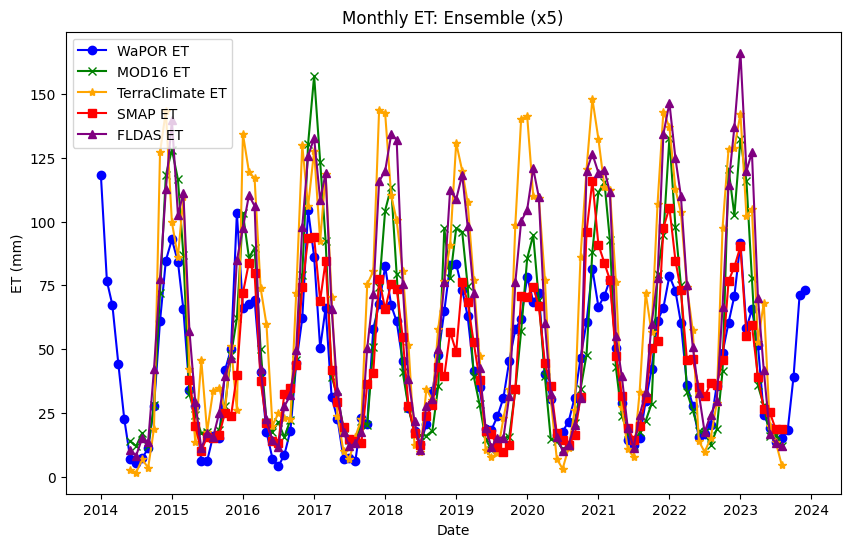

In [ ]:
import matplotlib.pyplot as plt

# Load the merged dataset
merged_df = pd.read_csv('merged_et_data.csv')

# Convert date to datetime for proper plotting
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(merged_df['date'], merged_df['WaPOR'], label='WaPOR ET', color='blue', marker='o')
plt.plot(merged_df['date'], merged_df['MOD16'], label='MOD16 ET', color='green', marker='x')
plt.plot(merged_df['date'], merged_df['TerraClimate'], label='TerraClimate ET', color='orange', marker='*')
plt.plot(merged_df['date'], merged_df['SMAP'], label='SMAP ET', color='red', marker='s')
plt.plot(merged_df['date'], merged_df['FLDAS'], label='FLDAS ET', color='purple', marker='^')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('ET (mm)')
plt.title('Monthly ET: Ensemble (x5)')
plt.legend()

# Display the plot
plt.show()


In [ ]:
from google.colab import files
files.download('merged_et_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# (vii) Calculate ensemble mean, min and max

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the merged dataset
data = pd.read_csv('merged_et_data.csv')

# Optional: Bring in field-observed ET to plot with the ensemble
observed_et = pd.read_csv('cp6_observed_et.csv')

In [ ]:
# Ensure both dataframes have the same length
if len(observed_et) == len(data):
    data = pd.concat([data, observed_et[['field_et']]], axis=1)
else:
    print("The dataframes do not have the same number of rows.")

# Display the resulting merged dataframe
print(data.head())

         date  WaPOR  MOD16  TerraClimate  FLDAS  SMAP  field_et
0  2014-01-01  118.2    NaN           NaN    NaN   NaN       NaN
1  2014-02-01   76.6    NaN           NaN    NaN   NaN       NaN
2  2014-03-01   67.3    NaN           NaN    NaN   NaN       NaN
3  2014-04-01   44.0    NaN           NaN    NaN   NaN       NaN
4  2014-05-01   22.7    NaN           NaN    NaN   NaN       NaN


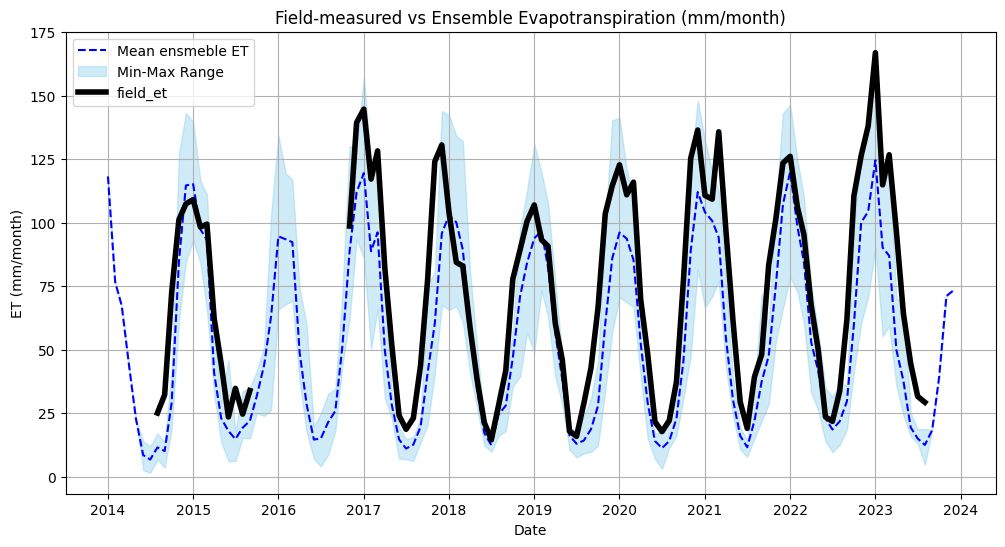

In [ ]:
# Convert the date column to datetime format
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Calculate the min, max, and mean values across the three products for each month
data['min_ET'] = data[['WaPOR', 'MOD16', 'TerraClimate', 'SMAP', 'FLDAS']].min(axis=1)
data['max_ET'] = data[['WaPOR', 'MOD16', 'TerraClimate', 'SMAP', 'FLDAS']].max(axis=1)
data['mean_ET'] = data[['WaPOR', 'MOD16', 'TerraClimate', 'SMAP', 'FLDAS']].mean(axis=1)

# Plot the ensemble with min-max range and mean line
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['mean_ET'], label='Mean ensmeble ET', color='blue', linestyle='--')
plt.fill_between(data.index, data['min_ET'], data['max_ET'], color='skyblue', alpha=0.4, label='Min-Max Range')

# Add observed data as a solid black line
plt.plot(data.index, data['field_et'], label='field_et', color='black', linestyle='-', linewidth=4)

plt.xlabel('Date')
plt.ylabel('ET (mm/month)')
plt.title('Field-measured vs Ensemble Evapotranspiration (mm/month)')
plt.legend()
plt.grid()

plt.show()

In [ ]:
# Calculate median for further intepretation
data['median_ET'] = data[['WaPOR', 'MOD16', 'TerraClimate', 'SMAP', 'FLDAS']].median(axis=1)

# Export min, max, median and mean ET values to CSV
data[['min_ET', 'max_ET', 'median_ET', 'mean_ET', 'field_et']].to_csv('CP6_ET_summary.csv', index=True)